# Detecting signs of depression in Social Media

## About data set and depression

This project is based on data set created by: 
S Kayalvizhi and D Thenmozhi in 2022. Paper: "Data set creation and empirical analysis for detecting signs of depression from social media postings."
The data set was collected from Reddit archives of subreddits groups like: Mental Health, depression, loneliness, stress, anxiety. Data were pre-processed by removing the non-ASCII characters and emoticons to get a clean data set.  The collected postings data were annotated by two domain experts into three labels: “Not depressed, Moderate and Severe".

“Not Depressed" was annotated when data reflect one of the following mannerism:
- If the statements have only one or two lines about irrelevant topics. 
- If the statements reflect momentary feelings of present situation.
- If the statements are about asking questions about any or medication 
- If the statement is about ask/seek help for friend’s difficulties.

“Moderately depressed" was annotated when data falls under these conditions:
- If the statements reflect change in feelings (feeling low for some time and feeling better for some time). 
- If the statement shows that they aren’t feeling completely immersed in any situations
- If the statements show that they have hope for life.

“Severely depressed" was annotated when data have one of the following scenarios:
- If the statements express more than one disorder conditions. 
- If the statements explain about history of suicide attempts.

Because depression can be diagnosed only by clinician expert using questionnaries, clinical interwiev, observation and other technics, this annotation as depressed and moderately depressed cannot be treated as a diagnosis. It is just assumed that the user has signs of depression based on his/her declaration. 

**So what added value could be for such project?**
In my opinion value could be significant:
Machine learning model could very fast detect signs which look like depression and could target such user with some information: for example, sending them information about local clinicians, about free help, invite to neerest places for diagnosis, propose conversation with dedicated chatbot or specialist. 
Depression is higly correlated with suicidality and this may be a far-reaching assumption, but it could save someone's life.

Let's start by importing all needed libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import casual_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Data preparation

The data set was stored in 3 files: train, dev and test. Test data did not have labels (because it was competition data to see competitors' scores) so train and dev were concatenated to have one data set.
Let's see the data.

In [2]:
df1 = pd.read_csv('train.tsv', sep='\t')
df2 = pd.read_csv('dev.tsv', sep='\t') 

In [3]:
df1.head()

,PID,Text_data,Label
0,train_pid_1,Waiting for my mind to have a breakdown once t...,moderate
1,train_pid_2,My new years resolution : I'm gonna get my ass...,moderate
2,train_pid_3,New year : Somone else Feeling like 2020 will ...,moderate
3,train_pid_4,"My story I guess : Hi, Im from Germany and my ...",moderate
4,train_pid_5,Sat in the dark and cried myself going into th...,moderate


In [4]:
df2.head()

,PID,Text data,Label
0,dev_pid_1,"I enjoyed today, and I still am! Tomorrows dep...",moderate
1,dev_pid_2,I sorta tried to kill myself : I had a total b...,moderate
2,dev_pid_3,Best suicide method? : I like it quick and eas...,moderate
3,dev_pid_4,a story : I remember the time I'd get on my 3D...,moderate
4,dev_pid_5,The world only cares about beautiful people : ...,moderate


We have different labels name and column "PID" is not necessary.

In [5]:
df2.rename({'Text data': 'Text_data'}, inplace=True, axis='columns')
df = pd.concat([df1, df2], ignore_index=True)
df.drop(["PID"], axis=1, inplace=True)
df.head()

,Text_data,Label
0,Waiting for my mind to have a breakdown once t...,moderate
1,My new years resolution : I'm gonna get my ass...,moderate
2,New year : Somone else Feeling like 2020 will ...,moderate
3,"My story I guess : Hi, Im from Germany and my ...",moderate
4,Sat in the dark and cried myself going into th...,moderate


In [6]:
df.shape

(13387, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13387 entries, 0 to 13386
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text_data  13387 non-null  object
 1   Label      13387 non-null  object
dtypes: object(2)
memory usage: 209.3+ KB


We can see we have 13387 rows and 2 columns. All data are in string format (object dtype). 
<br>Let's delete duplicates.

In [8]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [9]:
df.shape

(7115, 2)

We have a lot of duplicates, almost half have been deleted.

# Data exploration

Let's see how target column is distributed in the data.

In [10]:
df['Label'].value_counts()

moderate          3611
not depression    2742
severe             762
Name: Label, dtype: int64

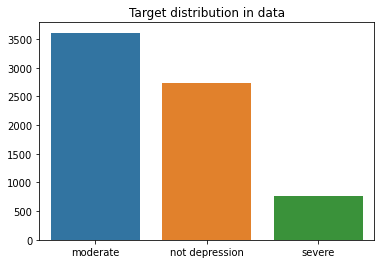

In [11]:
sns.barplot(x=df['Label'].value_counts().index, y=df['Label'].value_counts().values)
plt.title("Target distribution in data", fontsize=12)
plt.show()

Most rows are labeled as moderate depression (3611), in second place we have rows without depresion (2746) and the fewest: severe depression (762).
For this classification case we need to have labels 0, 1 and 2, because for some classifiers it is mandatory. To represent intensity of depression target will be changed as below:

In [12]:
df["Label"].replace({"not depression": 0, "moderate": 1, "severe": 2}, inplace=True)

Let's check what words are mostly used for severe, moderate and not depressed users. Will choose casual tokenizer which is dedicated to social media. We will also add lemmatizer (it will find the base word, not removing/replacing word suffixes as in stemmer) and delete English stop words. 

In [13]:
text_data_severe = df[df["Label"]==2]["Text_data"]
text_data_moderate = df[df["Label"]==1]["Text_data"]
text_data_not_depressed = df[df["Label"]==0]["Text_data"]

In [14]:
text_data_severe

599     Falling in love with depression and OCD. Anoth...
608     I’m so empty : I wake up to the malevolent gla...
609     I can't kill myself because of my parents : I ...
616     Feeling numb. : Okay this is my first post, ap...
639     I can't do this anymore. : I have several ment...
                              ...                        
7110    Aren’t we all just tired? : I’ve been depresse...
7111    NEED HELP COPING : I had my life pretty much f...
7112    Qutting Zoloft Cold Turkey : I was on 75 mg se...
7113    Crying : I’m coming off my antidepressants and...
7114    Seeking for advice on how to overcome and deal...
Name: Text_data, Length: 762, dtype: object

In [15]:
text_data_moderate

0       Waiting for my mind to have a breakdown once t...
1       My new years resolution : I'm gonna get my ass...
2       New year : Somone else Feeling like 2020 will ...
3       My story I guess : Hi, Im from Germany and my ...
4       Sat in the dark and cried myself going into th...
                              ...                        
4981    Lockdown has made so depressed : Help me, I fe...
4982    Am i just being dramatic? Do i really feel thi...
4983    Just another day of dealing with Depression. J...
4984    I just want to vent a bit, nothing special ple...
4985    Shit fucking day : Having the shittest day, do...
Name: Text_data, Length: 3611, dtype: object

In [16]:
text_data_not_depressed

597     i lost my virginity and 5 mins later my gf sai...
600     This is a question that gives me SO MUCH anxie...
601     Insecurities, fuck em. : I constantly feel lik...
602     i came here in reddit to be entertained. now i...
603     Empty : I wanted to have friends. People to sh...
                              ...                        
6770    I never feel like I'm enough and I can't get m...
6771    Just want to talk to someone real : I find mys...
6772    on the verge of tears but no real reason to cr...
6773    admitting to myself to the hospital tomorrow :...
6774    Does anyone else hate it when people say "You ...
Name: Text_data, Length: 2742, dtype: object

Let's prepare function for finding most common words from all type users.

In [19]:
stop_words = stopwords.words('english') 
wl = WordNetLemmatizer()

def count_words(data):
    '''
    Return counted words from data using stop words, casual tokenizer and lematizer
    
    :param data: DataFrame with data
    
    :return: list with counted words
    '''
    
    casual_tekenizer_lists = [casual_tokenize(post) for post in data]
    casual_tekenizer = list(np.concatenate(casual_tekenizer_lists).flat)
    without_stop_words = [word for word in casual_tekenizer if word.lower() not in stop_words and word.isalpha()]
    after_lem = [wl.lemmatize(word) for word in without_stop_words]
    
    return Counter(after_lem)

Let's check what are most common 20 words in the group with severe, moderate and without depression.

In [20]:
count_severe_words = count_words(text_data_severe)
top20_severe_words = count_severe_words.most_common(20)
print(top20_severe_words)

[('like', 1213), ('feel', 1200), ('want', 1073), ('get', 832), ('know', 820), ('time', 736), ('life', 704), ('year', 699), ('depression', 682), ('day', 622), ('even', 565), ('really', 555), ('thing', 526), ('friend', 518), ('go', 512), ('people', 503), ('would', 474), ('help', 443), ('one', 440), ('die', 433)]


In [21]:
count_moderate_words = count_words(text_data_moderate)
top20_moderate_words = count_moderate_words.most_common(20)
print(top20_moderate_words)

[('like', 4745), ('feel', 4719), ('know', 3190), ('want', 3122), ('life', 2802), ('get', 2794), ('time', 2695), ('friend', 2227), ('even', 2200), ('year', 2160), ('thing', 2029), ('really', 2017), ('people', 2009), ('day', 1845), ('one', 1837), ('go', 1682), ('would', 1608), ('make', 1555), ('depression', 1516), ('think', 1492)]


In [22]:
count_not_depressed_words = count_words(text_data_not_depressed)
top20_not_depressed_words = count_not_depressed_words.most_common(20)
print(top20_not_depressed_words)

[('like', 2141), ('feel', 2007), ('know', 1504), ('want', 1342), ('get', 1244), ('life', 1215), ('time', 1167), ('friend', 1066), ('people', 1057), ('really', 942), ('thing', 939), ('one', 937), ('even', 933), ('year', 891), ('day', 889), ('make', 778), ('go', 721), ('would', 711), ('think', 708), ('going', 680)]


We can see that many words are the same in all groups: like, feel, know, want etc. We would like to see what words are specific for each group. But before we do this, let's visiualise how 20 most common words are distributed on one group. For example for severly depressed.

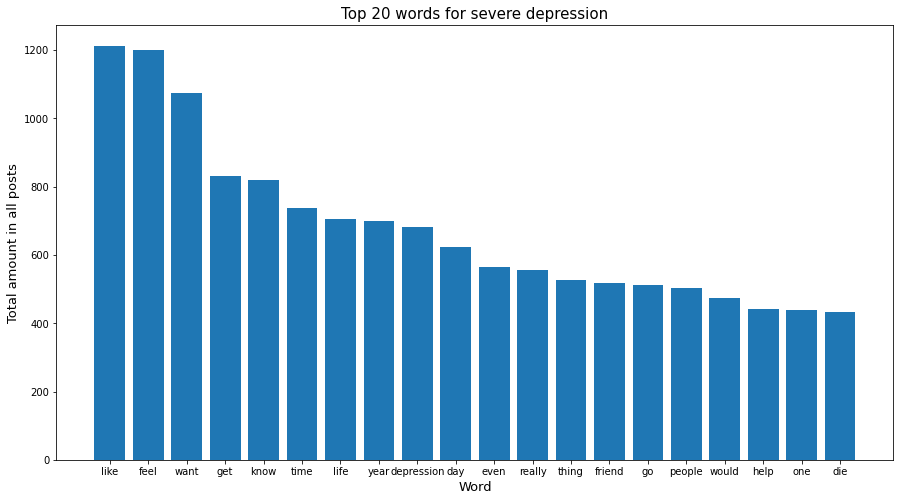

In [23]:
x_list_s20 = [x[0] for x in top20_severe_words]
y_list_s20 = [x[1] for x in top20_severe_words]

plt.figure(figsize=(15, 8))
plt.title("Top 20 words for severe depression", fontsize=15)
plt.xlabel("Word", fontsize=13)
plt.ylabel("Total amount in all posts", fontsize=13)
plt.bar(x=x_list_s20, height=y_list_s20)
plt.show()

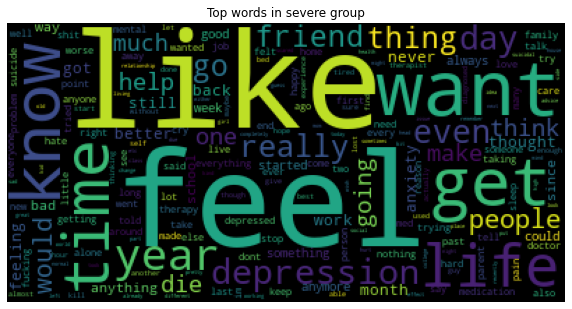

In [24]:
wc = WordCloud()
wc.generate_from_frequencies(count_severe_words)
plt.figure(figsize=(10, 8))
plt.title("Top words in severe group", fontsize=12)
plt.imshow(wc)
plt.axis('off')
plt.show()

We can see that three most popular words are: like, feel and want.
<br>Now, let's check what words are used in all groups simultaneously and what only in one of them (limited to 50 common words).

In [25]:
top50_severe_words = count_severe_words.most_common(50)
top50_moderate_words = count_moderate_words.most_common(50)
top50_not_depressed_words = count_not_depressed_words.most_common(50)

x_list_s50 = [x[0] for x in top50_severe_words]
x_list_m50 = [x[0] for x in top50_moderate_words]
x_list_n50 = [x[0] for x in top50_not_depressed_words]

In [26]:
words_in_all_groups = [x for x in x_list_s50 if x in x_list_m50 and x in x_list_n50]
print(f"List of words which are present in all groups (limited to top 50 words):\n{words_in_all_groups}")

List of words which are present in all groups (limited to top 50 words):
['like', 'feel', 'want', 'get', 'know', 'time', 'life', 'year', 'depression', 'day', 'even', 'really', 'thing', 'friend', 'go', 'people', 'would', 'help', 'one', 'think', 'going', 'make', 'much', 'thought', 'better', 'never', 'work', 'feeling', 'back', 'got', 'still', 'anything', 'school', 'way', 'anymore', 'could', 'something', 'good', 'always', 'everything']


In [27]:
words_only_in_severe50 = [x for x in x_list_s50 if x not in x_list_m50 and x not in x_list_n50]
print(f"List of words which are present only in severe group (limited to top 50 words):\n{words_only_in_severe50}")

List of words which are present only in severe group (limited to top 50 words):
['die', 'anxiety', 'month', 'since', 'bad', 'started', 'week', 'take']


In [28]:
words_only_in_moderate50 = [x for x in x_list_m50 if x not in x_list_s50 and x not in x_list_n50]
print(f"List of words which are present only in moderate group (limited to top 50 words):\n{words_only_in_moderate50}")

List of words which are present only in moderate group (limited to top 50 words):
['hate', 'nothing', 'family', 'happy', 'fucking']


When we limited to 50 most common words it looks very interesting: only people with severe depression use words "die", "anxiety" etc. and with moderate depression: 'hate', 'nothing' etc. Let's see how it will change when we expand it to 100 common words.

In [29]:
top100_severe_words = count_severe_words.most_common(100)
top100_moderate_words = count_moderate_words.most_common(100)
top100_not_depressed_words = count_not_depressed_words.most_common(100)

x_list_s100 = [x[0] for x in top100_severe_words]
x_list_m100 = [x[0] for x in top100_moderate_words]
x_list_n100 = [x[0] for x in top100_not_depressed_words]

In [30]:
words_only_in_severe100 = [x for x in x_list_s100 if x not in x_list_m100 and x not in x_list_n100]
print(f"List of words which are present only in severe group (limited to top 100 words):\n{words_only_in_severe100}")

List of words which are present only in severe group (limited to top 100 words):
['anxiety', 'medication', 'wanted', 'ago', 'therapy', 'past', 'stop', 'problem', 'went', 'mental', 'two']


In [31]:
words_only_in_moderate100 = [x for x in x_list_m100 if x not in x_list_s100 and x not in x_list_n100]
print(f"List of words which are present only in moderate group (limited to top 100 words):\n{words_only_in_moderate100}")

List of words which are present only in moderate group (limited to top 100 words):
['im', 'tired']


This is even more interesting. When we limit to 100 most common words, it looks like people only with severe depression are writing about snxiety, medication, therapy etc. For moderate only: i'm, tired.

# Baseline

Now, we will try to find the best baseline for upcoming modeling. At first, let's split data to train and test

In [32]:
X = df['Text_data']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y)

### CountVectorizer vs TFIDFVectorizer

Now we will find the best Vectorizer. Let's see how f1 scores (macro and weighted) look like for different vectorizers with different classification models.
<br>At first we prepared functions for calculations.

In [33]:
def f1_macro_avg(pipe, X, y):
    '''
    Calculate macro-averaged F1 score
    
    :param pipe: pipeline with classification model
    :param X: data without label column
    :param y: only label column for data
    
    :return: macro-averaged F1 score
    '''
        
    y_pred = pipe.predict(X)
    
    return f1_score(y_true=y, y_pred=y_pred, average='macro')  


def f1_weighted_avg(pipe, X, y):
    '''
    Calculate weighted-averaged F1 score
    
    :param pipe: pipeline with classification model
    :param X: data without label column
    :param y: only label column for data
    
    :return: weighted-averaged F1 score
    '''
        
    y_pred = pipe.predict(X)
    
    return f1_score(y_true=y, y_pred=y_pred, average='weighted')


def get_performance(pipe, X, y):
    '''
    Show string information about both macro and weighted F1 scores for one model.
    
    :param pipe: pipeline with classification model
    :param X: data without label column
    :param y: only label column for data
    
    :return: string with scores
    '''
    
    return f"F1 macro avg: {f1_macro_avg(pipe, X, y): .2f}, F1 weighted avg: {f1_weighted_avg(pipe, X, y): .2f} "


def basic_performance(vectorizer, clf_names, clf_models):
    '''
    Create dictionary with F1 scores for defined models
    
    :param vectorizer: vectorizer
    :param names: list of models names
    :param models: list of classification models
    
    :return: dictionary with scores from many models
    '''

    basic_performance = {}

    for model, name in zip(clf_models, clf_names):
        pipe = Pipeline([
        ('vct', vectorizer),
        (name ,model)
        ])
        pipe.fit(X_train, y_train)
        performance = get_performance(pipe, X_test, y_test)
        basic_performance[name] = performance
    
    return basic_performance

Prepare models:

In [35]:
names = ['LogRegr', 'SupVecM', 'MulNomB', 'DecTree', 'RandFor', 'XGBoost']

models = [LogisticRegression(max_iter=10000),
              SVC(),
              MultinomialNB(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              XGBClassifier()]

And check scores for CountVectorizer and TfidfVectorizer

In [36]:
basic_perf_countvectorizer = basic_performance(vectorizer=CountVectorizer(), clf_names=names, clf_models=models)

In [35]:
basic_perf_countvectorizer

{'LogRegr': 'F1 macro avg:  0.50, F1 weighted avg:  0.55 ',
 'SupVecM': 'F1 macro avg:  0.42, F1 weighted avg:  0.56 ',
 'MulNomB': 'F1 macro avg:  0.49, F1 weighted avg:  0.56 ',
 'DecTree': 'F1 macro avg:  0.42, F1 weighted avg:  0.50 ',
 'RandFor': 'F1 macro avg:  0.41, F1 weighted avg:  0.55 ',
 'XGBoost': 'F1 macro avg:  0.49, F1 weighted avg:  0.58 '}

In [39]:
basic_perf_tfidfvectorizer = basic_performance(vectorizer=TfidfVectorizer(), clf_names=names, clf_models=models)

In [40]:
basic_perf_tfidfvectorizer

{'LogRegr': 'F1 macro avg:  0.51, F1 weighted avg:  0.59 ',
 'SupVecM': 'F1 macro avg:  0.48, F1 weighted avg:  0.59 ',
 'MulNomB': 'F1 macro avg:  0.27, F1 weighted avg:  0.40 ',
 'DecTree': 'F1 macro avg:  0.42, F1 weighted avg:  0.49 ',
 'RandFor': 'F1 macro avg:  0.41, F1 weighted avg:  0.56 ',
 'XGBoost': 'F1 macro avg:  0.51, F1 weighted avg:  0.58 '}

We can see that F1 scores for CountVectorizer are relatively constans in small range: 
<br>macro:&emsp;&emsp;0.41 - 0.50 
<br>weighted: 0.50 - 0.58
<br>
<br>In TfidfVectorizer F1 is in wider range, but mostly higher than CountVectorizer:
<br>macro:&emsp;&emsp;0.27 - 0.51
<br>weighted: 0.40 - 0.59
<br>
<br> Only MultiNomialNB has better results in CountVectorizer than TfidfVectorizer, so for further modeling we will choose TFIDFvectorizer.
<br>Now let's try to find what is better for TfidfVectorizer performance: Stemmer or Lemmatizer.

### Stemming and Lematization

For both normalizing methods we will delete stop words and prepared needed classes and function.

In [41]:
stop_w = set(stopwords.words('english'))

class LemTokenizer:
    '''
    Class for Lemmatizer
    
    :return: doc after lemmatization without stop words and non alfanum
    '''
    
    def __init__(self):
        
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, doc):
        
        return [self.wnl.lemmatize(w) for w in casual_tokenize(doc) if w not in stop_w and w.isalnum()]


class StemTokenizer:
    '''
    Class for Stemmer  
    
    :return: doc after stemming without stop words and non alfanum
    '''
    
    def __init__(self):
        
        self.ps = PorterStemmer()

    def __call__(self, doc):
        
        return [self.ps.stem(w) for w in casual_tokenize(doc) if w not in stop_w and w.isalnum()]


def performance_with_text_normalization(tokenizer_class, clf_names, clf_models):
    '''
    Create dictionary with F1 scores for defined models with TfidfVectorizer
    and Lemmer/Stemmer tokenization classes.
    
    :param tokenizer: tokenizer class (LemTokenizer or StemTokenizer)
    :param names: list of models names
    :param models: list of classification models
    
    :return: dictionary with scores from many models
    '''

    basic_performance = {}

    for model, name in zip(clf_models, clf_names):
        pipe = Pipeline([
        ('vct', TfidfVectorizer(tokenizer=tokenizer_class)),
        (name ,model)
        ])
        pipe.fit(X_train, y_train)
        performance = get_performance(pipe, X_test, y_test)
        basic_performance[name] = performance
    
    return basic_performance

And check scores for Lematization and Stemming

In [42]:
basic_lema_perf = performance_with_text_normalization(tokenizer_class=LemTokenizer(), clf_names=names, clf_models=models)

In [43]:
basic_lema_perf

{'LogRegr': 'F1 macro avg:  0.51, F1 weighted avg:  0.58 ',
 'SupVecM': 'F1 macro avg:  0.48, F1 weighted avg:  0.58 ',
 'MulNomB': 'F1 macro avg:  0.28, F1 weighted avg:  0.41 ',
 'DecTree': 'F1 macro avg:  0.45, F1 weighted avg:  0.51 ',
 'RandFor': 'F1 macro avg:  0.42, F1 weighted avg:  0.56 ',
 'XGBoost': 'F1 macro avg:  0.51, F1 weighted avg:  0.57 '}

In [44]:
basic_stem_perf = performance_with_text_normalization(tokenizer_class=StemTokenizer(), clf_names=names, clf_models=models)

In [45]:
basic_stem_perf

{'LogRegr': 'F1 macro avg:  0.51, F1 weighted avg:  0.59 ',
 'SupVecM': 'F1 macro avg:  0.49, F1 weighted avg:  0.58 ',
 'MulNomB': 'F1 macro avg:  0.29, F1 weighted avg:  0.42 ',
 'DecTree': 'F1 macro avg:  0.42, F1 weighted avg:  0.49 ',
 'RandFor': 'F1 macro avg:  0.42, F1 weighted avg:  0.56 ',
 'XGBoost': 'F1 macro avg:  0.52, F1 weighted avg:  0.59 '}

We can see that there is no big differences between Stemmer and Lemmatizer, so we will choose Lemmatizer because stemmer is more agressiv. 
<br> We can also see that the best three classificators are: Logistic Regression, Support Vector Machines and XGBoost.

Summarizing, for baseline we will have TfidfVectorizer, lemmatization without english stop words and without non alpha-numeric characters.

# MODELING

Now, we are going to  look for best scores of three models: Logistic Regression, Support Vector Machines and XGBoost. For every model we will have the same steps in the same order as listed below:
- Create pipeline
- Define grid parameters for hypertuning
- Perform gridsearch and find best parameters
- Check scores for: baseline model and model with best parameters

Let's prepare functions for those steps:

In [46]:
def create_pipeline(model, name):
    '''
    Create pipeline for defined classifier
    
    :param model: classification model
    :param name: name for classification model
    
    :return: pipeline object
    '''

    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=LemTokenizer())),
        (name ,model)
        ])
    
    return pipe


def find_best_estimator(pipe, params, cv, X_train, y_train):
    '''
    Perform GridSearchCV to optimaze hyperparameters. Print best parameters and return model.
 
    :param pipe: pipeline with classifier
    :param params: parameters grid
    :param cv: number of folds in cross validation      
    :param X_train: traning data without label column
    :param y_train: only label column for training data
    
    :return: classification model with best parameters
    '''
    
    gs = GridSearchCV(estimator = pipe, 
                      param_grid = params, 
                      cv = cv, 
                      n_jobs = -1, # (-1 means using all processors, None default)
                      verbose = 1,
                      scoring= 'f1_macro')
    gs.fit(X_train,y_train)
    print('Best parameters found: ')
    print(gs.best_params_)
    
    return gs.best_estimator_


def show_best_model_score(model, X_test, y_test):
    '''
    Print classification report.
 
    :param model: fitted model with best parameters   
    :param X_test: test data without label column
    :param y_test: only label column for test data

    '''
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))

In [74]:
# check vocabulary len
# tfidf = TfidfVectorizer(tokenizer=LemTokenizer()).fit(X_train,y_train)
# print(tfidf.vocabulary_.__len__()) 

### Logistic Regression

In [92]:
log_reg_pipeline = create_pipeline(LogisticRegression(max_iter=10000), 'log_reg')

log_reg_param = {
 'tfidf__max_features':[5000, 10000, None],         # default None , vocabulary len is 14k
 'tfidf__ngram_range': [(1, 1), (1, 2)],            # default (1, 1)
 'log_reg__penalty': ['l1', 'l2'],                  # default l2
 'log_reg__solver': ['lbfgs', 'liblinear', 'saga'], # default lbfgs  
 'log_reg__C': [10, 1.0, 0.1]                       # default 1
}

In [93]:
best_log_reg = find_best_estimator(pipe=log_reg_pipeline, params=log_reg_param, cv=3, X_train=X_train, y_train=y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
54 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/lib/python3

Best parameters found: 
{'log_reg__C': 1.0, 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}


Score for Logistic Regresion baseline:

In [94]:
log_regr_baseline = create_pipeline(LogisticRegression(max_iter=10000), 'log_reg')
log_regr_baseline.fit(X_train,y_train)
show_best_model_score(model=log_regr_baseline, X_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.59      0.50      0.54       823
           1       0.60      0.76      0.67      1083
           2       0.73      0.20      0.31       229

    accuracy                           0.60      2135
   macro avg       0.64      0.49      0.51      2135
weighted avg       0.61      0.60      0.58      2135



Score for Logistic Regresion with best parameters:

In [95]:
show_best_model_score(model=best_log_reg, X_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.60      0.49      0.54       823
           1       0.60      0.76      0.67      1083
           2       0.67      0.24      0.35       229

    accuracy                           0.60      2135
   macro avg       0.62      0.50      0.52      2135
weighted avg       0.61      0.60      0.59      2135



Hypertuning for Logistic Regression did not help much, F1-macro and F1-weighted have beed improved by 0.1.

### Support Vector Machines

In [98]:
svc_pipeline = create_pipeline(SVC(), 'svc')

svc_param = {
 'tfidf__max_features':[5000, 10000, None],
 'tfidf__ngram_range': [(1, 1), (1, 2)],
 'svc__kernel': ['linear', 'rbf', 'poly'],   
 'svc__C': [10, 1, 0.1]
}

In [99]:
best_svc = find_best_estimator(pipe=svc_pipeline, params=svc_param, cv=3, X_train=X_train, y_train=y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters found: 
{'svc__C': 10, 'svc__kernel': 'linear', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}


Score for Support Vector Machines baseline:

In [100]:
svc_baseline = create_pipeline(SVC(), 'svc')
svc_baseline.fit(X_train,y_train)
show_best_model_score(model=svc_baseline, X_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.64      0.47      0.54       823
           1       0.60      0.82      0.69      1083
           2       0.75      0.13      0.22       229

    accuracy                           0.61      2135
   macro avg       0.66      0.47      0.48      2135
weighted avg       0.63      0.61      0.58      2135



Score for Support Vector Machines with best parameters:

In [101]:
show_best_model_score(model=best_svc, X_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.61      0.42      0.50       823
           1       0.59      0.78      0.67      1083
           2       0.57      0.33      0.42       229

    accuracy                           0.59      2135
   macro avg       0.59      0.51      0.53      2135
weighted avg       0.59      0.59      0.58      2135



Hypertuning for Support Vector Machines did not help much, only F1-macro has beed improved by 0.5.

### XGBoost

In [48]:
xgb_pipeline = create_pipeline(XGBClassifier(), 'xgb')

xgb_param = {
 'tfidf__max_features':[5000, 10000, None],
 'tfidf__ngram_range': [(1, 1), (1, 2)],
 'xgb__max_depth': [5, 6, 7],   # default 6
 'xgb__learning_rate': [0.2, 0.3, 0.4] # default 0.3
}

In [49]:
best_xgb = find_best_estimator(pipe=xgb_pipeline, params=xgb_param, cv=3, X_train=X_train, y_train=y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters found: 
{'tfidf__max_features': None, 'tfidf__ngram_range': (1, 1), 'xgb__learning_rate': 0.4, 'xgb__max_depth': 6}


Score for XGBoost baseline:

In [50]:
xgb_baseline = create_pipeline(XGBClassifier(), 'xgb')
xgb_baseline.fit(X_train,y_train)
show_best_model_score(model=xgb_baseline, X_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.58      0.50      0.54       823
           1       0.59      0.72      0.65      1083
           2       0.53      0.25      0.34       229

    accuracy                           0.59      2135
   macro avg       0.57      0.49      0.51      2135
weighted avg       0.58      0.59      0.57      2135



Score for XGBoost with best parameters:

In [51]:
show_best_model_score(model=best_xgb, X_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.58      0.51      0.54       823
           1       0.59      0.72      0.65      1083
           2       0.56      0.22      0.32       229

    accuracy                           0.59      2135
   macro avg       0.58      0.48      0.50      2135
weighted avg       0.58      0.59      0.57      2135



Hypertuning for XGBoost did not help much. Let's check models for neural networks.

# Neural Networks

In [52]:
import re
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, LSTM, Dropout, SimpleRNN, Bidirectional, GRU

Preparing data:

In [398]:
df1 = pd.read_csv('train.tsv', sep='\t')
df2 = pd.read_csv('dev.tsv', sep='\t')
df2.rename({'Text data': 'Text_data'}, inplace=True, axis='columns')
df = pd.concat([df1, df2], ignore_index=True)
df.drop(["PID"], axis=1, inplace=True)
df.drop_duplicates(inplace=True, ignore_index=True)
X = df['Text_data']
y = df['Label']

In [399]:
def preprocess(text):
    txt = re.sub('https?:\/\/.*','',text)   # delete links
    txt = re.sub('\d',' ', txt)  # delete numbers
    return txt

In [400]:
X = [preprocess(el) for el in X]

Tokenization will be executed using TextVectorization and tokens will be lomit to 5000.

In [401]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=5000, output_mode="int", output_sequence_length=40)

In [402]:
vectorize_layer.adapt(X)

In [403]:
vectorize_layer(X)

<tf.Tensor: shape=(7115, 40), dtype=int64, numpy=
array([[ 653,   15,    6, ...,  189,  194,   52],
       [   6,  157,   88, ...,   14,    7,  217],
       [ 157,  111,    1, ...,    0,    0,    0],
       ...,
       [   1, 1711,  935, ...,  650,    6,  656],
       [ 285,   35,  512, ...,    1,    4, 1535],
       [1404,   15,  358, ...,   17,   46,    7]], dtype=int64)>

In [404]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'i',
 'to',
 'and',
 'the',
 'my',
 'a',
 'of',
 'me',
 'it',
 'that',
 'in',
 'but',
 'just',
 'for',
 'is',
 'have',
 'this',
 'with',
 'so',
 'was',
 'like',
 'im',
 'feel',
 'be',
 'you',
 'not',
 'do',
 'on',
 'all',
 'or',
 'want',
 'know',
 'dont',
 'i’m',
 'about',
 'at',
 'out',
 'because',
 'life',
 'get',
 'if',
 'myself',
 'what',
 'up',
 'been',
 'am',
 'even',
 'when',
 'no',
 'as',
 'time',
 'how',
 'people',
 'they',
 'really',
 'now',
 'had',
 'she',
 'its',
 'one',
 'her',
 'from',
 'can',
 'are',
 'don’t',
 'depression',
 'would',
 'he',
 'friends',
 'go',
 'ive',
 'will',
 'them',
 'going',
 'never',
 'think',
 'cant',
 'being',
 'day',
 'much',
 'more',
 'things',
 'we',
 'help',
 'only',
 'has',
 'years',
 'some',
 'there',
 'who',
 'an',
 'anything',
 'better',
 'it’s',
 'something',
 'then',
 'back',
 'good',
 'why',
 'i’ve',
 'make',
 'everything',
 'always',
 'any',
 'still',
 'way',
 'feeling',
 'anymore',
 'by',
 'year',
 'someone',
 'too',
 

Let's prepare target matrix:

In [405]:
le = LabelEncoder()

In [406]:
y_labels = le.fit_transform(y)

In [407]:
y_labels

array([0, 0, 0, ..., 2, 2, 2])

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.15)

In [409]:
vocab_size = len(vectorize_layer.get_vocabulary())

In [410]:
vocab_size

5000

In [411]:
y_train[:20]

array([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

Now, we will check three neural networks: with SimpleRNN, with LSTM and Conv1D with hidden layer.

# Simple RNN

In [412]:
model1 = Sequential()
model1.add(vectorize_layer)
model1.add(Embedding(vocab_size, 25))
model1.add(SimpleRNN(32))
model1.add(Dense(3, activation="softmax"))

print(model1.summary())

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_26 (Text  (None, 40)               0         
 Vectorization)                                                  
                                                                 
 embedding_72 (Embedding)    (None, 40, 25)            125000    
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 32)                1856      
                                                                 
 dense_83 (Dense)            (None, 3)                 99        
                                                                 
Total params: 126,955
Trainable params: 126,955
Non-trainable params: 0
_________________________________________________________________
None


In [413]:
model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"])

model1.fit(
    np.array(X_train),
    y_train,
    batch_size=32,
    epochs=100,
    callbacks=[EarlyStopping(patience=2,monitor="val_loss")],
    validation_split=0.1
)

model1.evaluate(np.array(X_test), y_test)

Epoch 1/100
171/171 [==============================] - 4s 17ms/step - loss: 0.9321 - sparse_categorical_accuracy: 0.5502 - val_loss: 0.9077 - val_sparse_categorical_accuracy: 0.5835
Epoch 2/100
171/171 [==============================] - 3s 15ms/step - loss: 0.8436 - sparse_categorical_accuracy: 0.6064 - val_loss: 0.8956 - val_sparse_categorical_accuracy: 0.5719
Epoch 3/100
171/171 [==============================] - 2s 14ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.7495 - val_loss: 1.0498 - val_sparse_categorical_accuracy: 0.5174
Epoch 4/100
34/34 [==============================] - 0s 7ms/step - loss: 1.1721 - sparse_categorical_accuracy: 0.4981


[1.1721471548080444, 0.4981273412704468]

# LSTM

In [414]:
model2 = Sequential()
model2.add(vectorize_layer)
model2.add(Embedding(vocab_size, 25))
model2.add(LSTM(32))
model2.add(Dense(3, activation="softmax"))

print(model2.summary())

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_26 (Text  (None, 40)               0         
 Vectorization)                                                  
                                                                 
 embedding_73 (Embedding)    (None, 40, 25)            125000    
                                                                 
 lstm_25 (LSTM)              (None, 32)                7424      
                                                                 
 dense_84 (Dense)            (None, 3)                 99        
                                                                 
Total params: 132,523
Trainable params: 132,523
Non-trainable params: 0
_________________________________________________________________
None


In [415]:
model2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"])

model2.fit(
    np.array(X_train),
    y_train,
    batch_size=32,
    epochs=100,
    callbacks=[EarlyStopping(patience=2,monitor="val_loss")],
    validation_split=0.1
)

model2.evaluate(np.array(X_test), y_test)

Epoch 1/100
171/171 [==============================] - 7s 26ms/step - loss: 0.9322 - sparse_categorical_accuracy: 0.5507 - val_loss: 0.8773 - val_sparse_categorical_accuracy: 0.5769
Epoch 2/100
171/171 [==============================] - 4s 21ms/step - loss: 0.8273 - sparse_categorical_accuracy: 0.5970 - val_loss: 0.8474 - val_sparse_categorical_accuracy: 0.5950
Epoch 3/100
171/171 [==============================] - 4s 22ms/step - loss: 0.7386 - sparse_categorical_accuracy: 0.6588 - val_loss: 0.9176 - val_sparse_categorical_accuracy: 0.5471
Epoch 4/100
34/34 [==============================] - 0s 10ms/step - loss: 1.0075 - sparse_categorical_accuracy: 0.5581


[1.0075290203094482, 0.5580524206161499]

# Conv1D

In [420]:
model3 = Sequential()
model3.add(vectorize_layer)
model3.add(Embedding(vocab_size, 25))
model3.add(Conv1D(8, kernel_size=5))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(3, activation="softmax"))

print(model3.summary())

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_26 (Text  (None, 40)               0         
 Vectorization)                                                  
                                                                 
 embedding_76 (Embedding)    (None, 40, 25)            125000    
                                                                 
 conv1d_47 (Conv1D)          (None, 36, 8)             1008      
                                                                 
 global_max_pooling1d_39 (Gl  (None, 8)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_89 (Dense)            (None, 3)                 27        
                                                                 
Total params: 126,035
Trainable params: 126,035
Non-t

In [421]:
model3.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"])

model3.fit(
    np.array(X_train),
    y_train,
    batch_size=32,
    epochs=100,
    callbacks=[EarlyStopping(patience=2,monitor="val_loss")],
    validation_split=0.1
)

model3.evaluate(np.array(X_test), y_test)

Epoch 1/100
171/171 [==============================] - 2s 10ms/step - loss: 0.9957 - sparse_categorical_accuracy: 0.4842 - val_loss: 0.9026 - val_sparse_categorical_accuracy: 0.5868
Epoch 2/100
171/171 [==============================] - 1s 8ms/step - loss: 0.8753 - sparse_categorical_accuracy: 0.5779 - val_loss: 0.8774 - val_sparse_categorical_accuracy: 0.5835
Epoch 3/100
171/171 [==============================] - 1s 8ms/step - loss: 0.8077 - sparse_categorical_accuracy: 0.6086 - val_loss: 0.8637 - val_sparse_categorical_accuracy: 0.5818
Epoch 4/100
171/171 [==============================] - 1s 8ms/step - loss: 0.7143 - sparse_categorical_accuracy: 0.6891 - val_loss: 0.8881 - val_sparse_categorical_accuracy: 0.5835
Epoch 5/100
34/34 [==============================] - 0s 6ms/step - loss: 0.9484 - sparse_categorical_accuracy: 0.5487


[0.9483864903450012, 0.5486891269683838]

We can see that the best score is for LSTM.